In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

### 1. Particles with ZA
First, load the density field computed from the particle distribution.
The initial condition is generated based on ZA by monofonic but it is at very high redshift ($z=99$). It is expected the distribution is almost the same as the initial GRF field, at which we will look later.

In [2]:
fname = "delta_icspart_ng512.dat"

N = np.fromfile(fname, count=1, dtype=np.int32)[0]
delta_part = np.fromfile(fname, count=N*N*N, dtype=np.float64, offset=4)
delta_part = delta_part.reshape((N, N, N))

print("N:", N)

N: 512


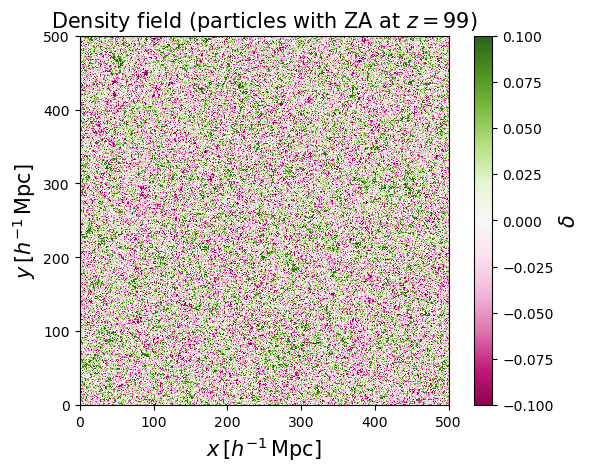

In [3]:
L = 500.0  # Mpc/h
x = np.linspace(0.0, L, N)
X, Y = np.meshgrid(x, x, indexing="ij")

plt.pcolormesh(X, Y, delta_part[:, :, N//2], vmin=-0.1, vmax=0.1, cmap="PiYG")
plt.gca().set_aspect('equal')

plt.xlabel(r"$x \, [h^{-1} \, \mathrm{Mpc}]$", fontsize=15)
plt.ylabel(r"$y \, [h^{-1} \, \mathrm{Mpc}]$", fontsize=15)
plt.title(r"Density field (particles with ZA at $z = 99$)", fontsize=15)
cb = plt.colorbar()
cb.set_label(label=r"$\delta$", fontsize=15)

plt.show()

## 2. GRF density field (`DM_delta`)
The initial GRF density field (labelled as `DM_delta`) is stored in "Generic HDF5 output format" of monofonic. This is also generated at $z = 99$.

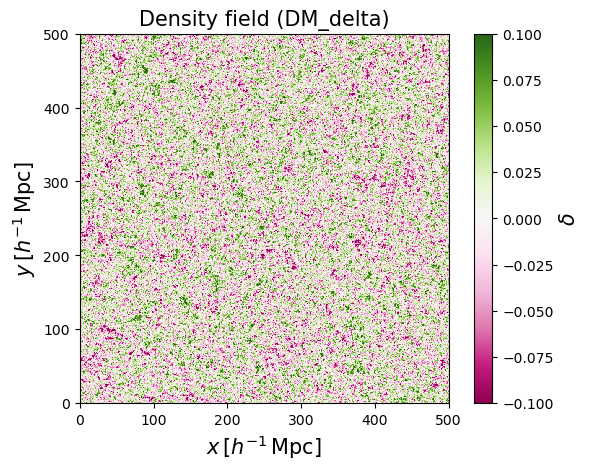

In [4]:
with h5py.File("delta_z99_ng512.hdf5") as f:
    delta_GRF = np.array(f["DM_delta"][:])

L = 500.0  # Mpc/h
x = np.linspace(0.0, L, N)
X, Y = np.meshgrid(x, x, indexing="ij")

plt.pcolormesh(X, Y, delta_GRF[:, :, N//2], vmin=-0.1, vmax=0.1, cmap="PiYG")
plt.gca().set_aspect('equal')

plt.xlabel(r"$x \, [h^{-1} \, \mathrm{Mpc}]$", fontsize=15)
plt.ylabel(r"$y \, [h^{-1} \, \mathrm{Mpc}]$", fontsize=15)
plt.title(r"Density field (DM_delta)", fontsize=15)
cb = plt.colorbar()
cb.set_label(label=r"$\delta$", fontsize=15)

plt.show()

Visually, we can see the same pattern but it looks like the sign is flipped. Let's take a closer look.

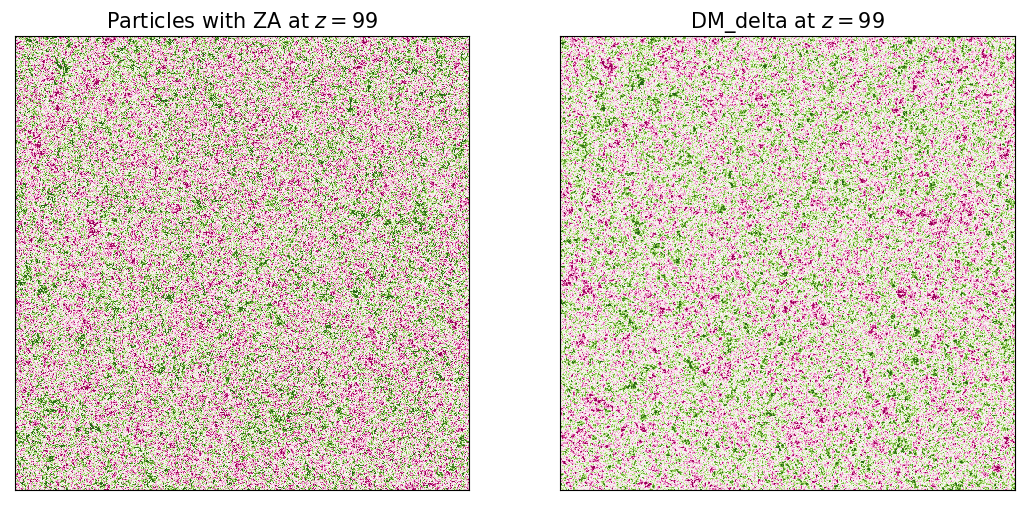

In [5]:
plt.figure(figsize=(8.6*1.5, 4.3*1.5))
plt.subplot(121)

plt.pcolormesh(X, Y, delta_part[:, :, N//2], vmin=-0.1, vmax=0.1, cmap="PiYG")
plt.gca().set_aspect('equal')

plt.xticks([])
plt.yticks([])
plt.title(r"Particles with ZA at $z = 99$", fontsize=15)

plt.subplot(122)

plt.pcolormesh(X, Y, delta_GRF[:, :, N//2], vmin=-0.1, vmax=0.1, cmap="PiYG")
plt.gca().set_aspect('equal')

plt.xticks([])
plt.yticks([])
plt.title(r"DM_delta at $z = 99$", fontsize=15)

plt.show()

Then, let's compare the density fields at the voxel level. The figure shows the histogram of the ratio of the density fields. Due to the discreteness of particles, there are some fluctuations but the central value is close to "-1".

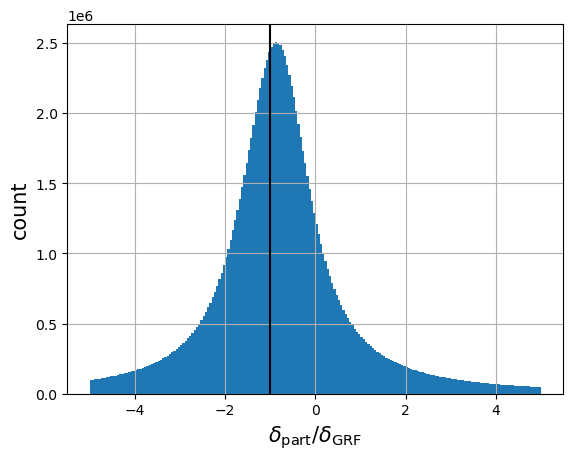

In [6]:
ratio = delta_part/delta_GRF
ratio = ratio.flatten()

plt.hist(ratio, bins=200, range=(-5.0, 5.0))
plt.axvline(-1.0, c="k")

plt.xlabel(r"$\delta_\mathrm{part} / \delta_\mathrm{GRF}$", fontsize=15)
plt.ylabel(r"count", fontsize=15)
plt.grid()
plt.show()

For sanity check, here I measure the power spectra of both density fields and confirm they have exactly the same spectra.

In [7]:
# define k binning
Nbin = 30
kmin = 0.01
kmax = 1.0
kny = np.pi/(L/N)

k1 = (2.0*np.pi*N/L)*np.fft.fftfreq(N)
kx, ky, kz = np.meshgrid(k1, k1, k1, indexing='ij')
k = np.sqrt(kx**2 + ky**2 + kz**2)

Nk, bin_edges = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin)

kbin, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=k.flatten())
kbin = kbin/Nk

deltak = np.fft.fftn(delta_part)
Pk_part = (deltak*deltak.conj()).real
Pkbin_part, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=Pk_part.flatten())
Pkbin_part = L**3*Pkbin_part/Nk/(N**6)

deltak = np.fft.fftn(delta_GRF)
Pk_GRF = (deltak*deltak.conj()).real
Pkbin_GRF, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=Pk_GRF.flatten())
Pkbin_GRF = L**3*Pkbin_GRF/Nk/(N**6)

/tmp/ipykernel_38245/123636697.py:11: RuntimeWarning: divide by zero encountered in log10
  Nk, bin_edges = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin)
/tmp/ipykernel_38245/123636697.py:13: RuntimeWarning: divide by zero encountered in log10
  kbin, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=k.flatten())
/tmp/ipykernel_38245/123636697.py:14: RuntimeWarning: invalid value encountered in divide
  kbin = kbin/Nk
/tmp/ipykernel_38245/123636697.py:18: RuntimeWarning: divide by zero encountered in log10
  Pkbin_part, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=Pk_part.flatten())
/tmp/ipykernel_38245/123636697.py:19: RuntimeWarning: invalid value encountered in divide
  Pkbin_part = L**3*Pkbin_part/Nk/(N**6)
/tmp/ipykernel_38245/123636697.py:23: RuntimeWarning: divide by zero encountered in log10
  Pkbin_GRF, _ = np.histogram(np.log10(k.flat

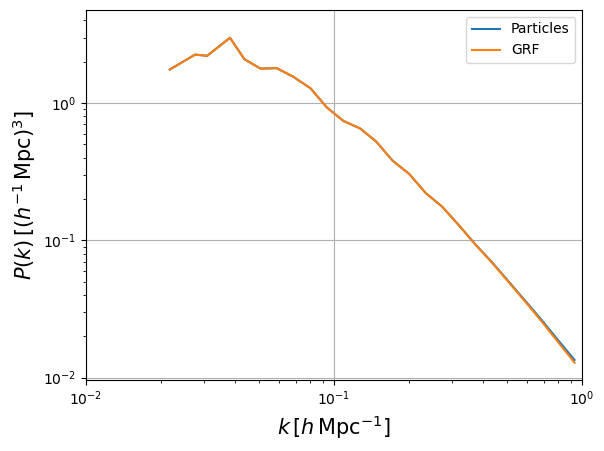

In [8]:
plt.loglog(kbin, Pkbin_part, label="Particles")
plt.loglog(kbin, Pkbin_GRF, label="GRF")

plt.xlabel(r"$k \, [h \, \mathrm{Mpc}^{-1}]$", fontsize=15)
plt.ylabel(r"$P(k) \, [(h^{-1} \, \mathrm{Mpc})^3]$", fontsize=15)
plt.xlim(0.01, 1.0)
plt.grid()
plt.legend()

plt.show()